### Задание 1

#### Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).

In [1]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5))

series = read_csv('Sunspots - Sunspots.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
print(series.head(13))

with plt.style.context('ggplot'):
    series.plot()
    plt.show()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
1749-06-30    139.2
1749-07-31    158.0
1749-08-31    110.5
1749-09-30    126.5
1749-10-31    125.8
1749-11-30    264.3
1749-12-31    142.0
1750-01-31    122.2
Name: Monthly Mean Total Sunspot Number, dtype: float64


<Figure size 1500x500 with 1 Axes>

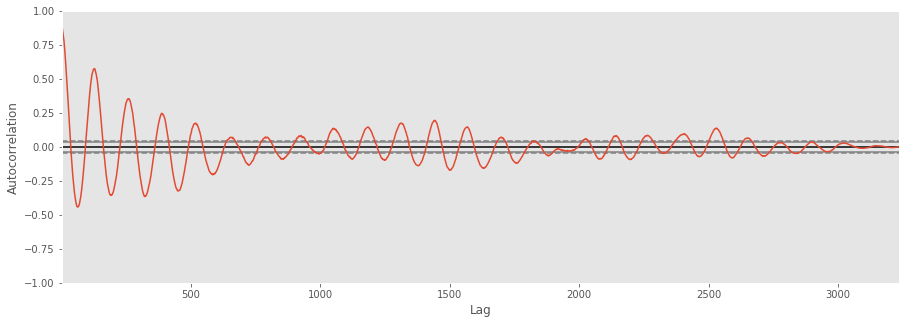

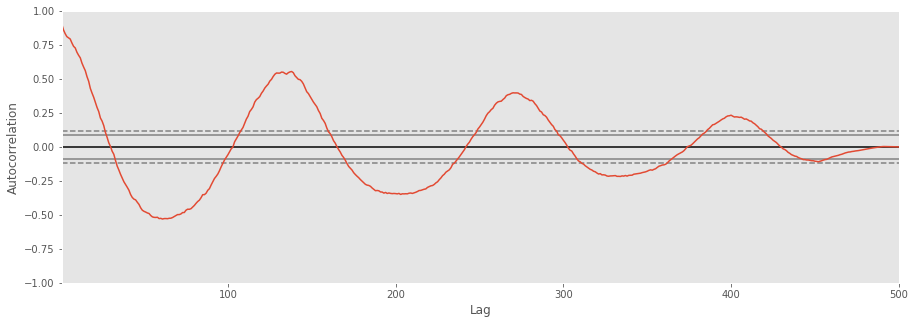

In [2]:
from pandas.plotting import autocorrelation_plot

with plt.style.context('ggplot'):
    plt.figure(figsize=(15, 5))

    autocorrelation_plot(series)
    plt.show()

    plt.figure(figsize=(15, 5))

    autocorrelation_plot(series[1000:1500])
    plt.show()

## ≈ 130 Years

In [3]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(7,1,0), freq=series.index.inferred_freq)
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/a_stasiuk/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                                      ARIMA Model Results                                      
Dep. Variable:     D.Monthly Mean Total Sunspot Number   No. Observations:                 3234
Model:                                  ARIMA(7, 1, 0)   Log Likelihood              -15030.967
Method:                                        css-mle   S.D. of innovations             25.250
Date:                                 Mon, 20 Apr 2020   AIC                          30079.934
Time:                                         23:44:24   BIC                          30134.667
Sample:                                     02-28-1749   HQIC                         30099.546
                                          - 07-31-2018                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const       

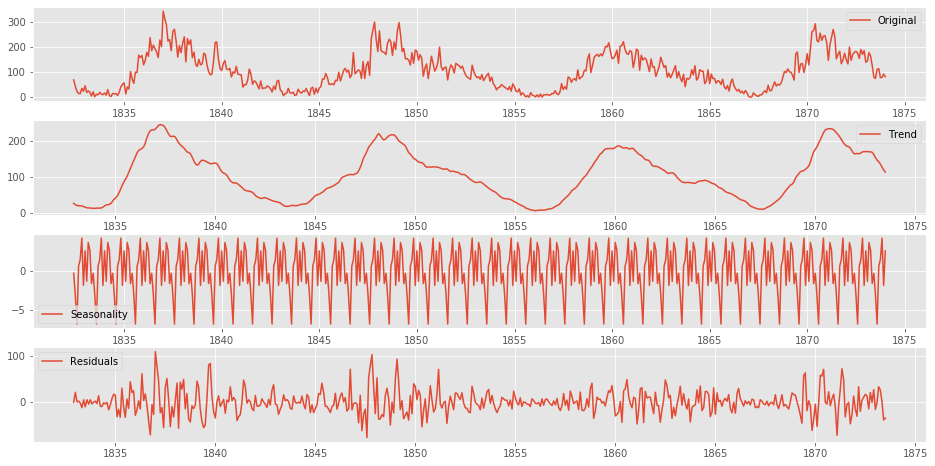

In [4]:
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(series[1000:1500])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))
    plt.subplot(411)
    plt.plot(series[1000:1500], label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.show()

### Задание 2, 3

#### Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки. Примените модель ARIMA для прогнозирования значений данного временного ряда.

In [5]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

def evaluate(X, order):
    train_size = int(len(X) * 0.85)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in tqdm(range(len(test))):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error, test, predictions

In [6]:
mse, test, preds = evaluate(series, order=(5,1,0))

 53%|█████▎    | 258/486 [00:28<00:25,  9.11it/s]/home/a_stasiuk/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 486/486 [00:53<00:00,  9.10it/s]


In [7]:
preds = [x[0] for x in preds]

ARIMA MSE=607.185


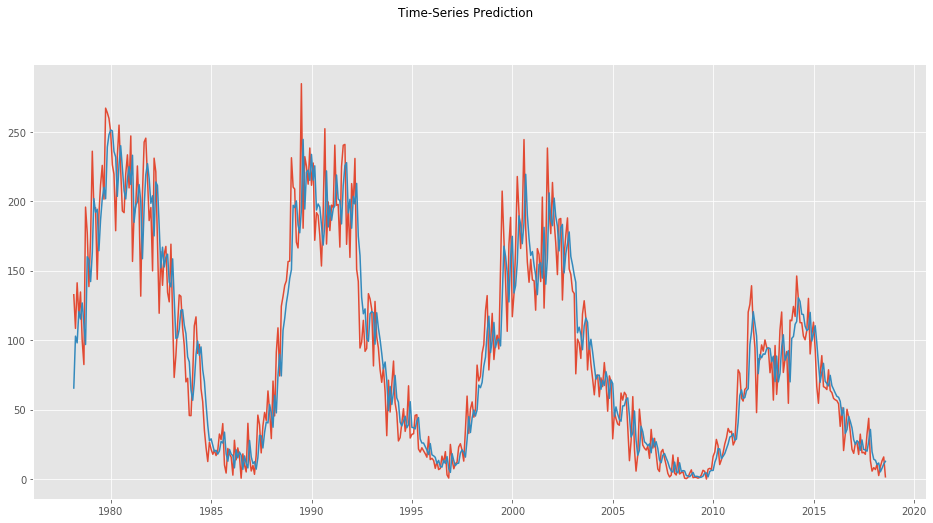

In [8]:
import pandas as pd

preds = pd.Series(preds, index=test.index)

with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))

    plt.plot(test)
    plt.plot(preds)
    plt.suptitle('Time-Series Prediction')
    print('ARIMA MSE={}'.format(round(mse, 3)))
    plt.show()

### Задание 4

#### Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).

In [9]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [10]:
sc = MinMaxScaler()
training_data = sc.fit_transform(series.values.reshape(-1, 1) )

In [11]:
seq_length = 30

import numpy as np

def get_sequences(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

x, y = get_sequences(training_data, seq_length)

In [12]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

train_size, test_size

(2146, 1058)

In [13]:
import torch

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [14]:
from lstm_model import LSTM

num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 5
num_layers = 1

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

100%|██████████| 200/200 [00:18<00:00, 11.07it/s]


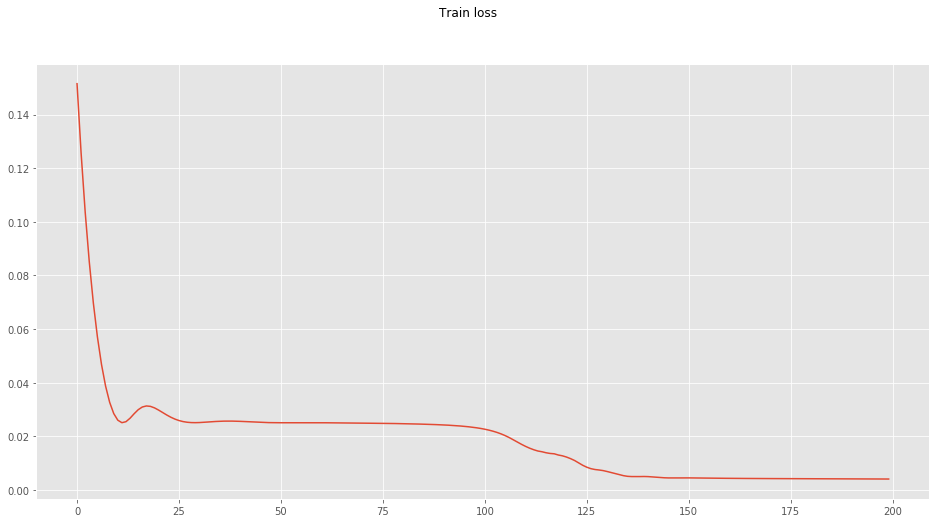

In [15]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

logs = {}

from tqdm import tqdm

for epoch in tqdm(range(num_epochs)):
    outputs = model(trainX)
    optimizer.zero_grad()
    
    loss = criterion(outputs, trainY)    
    loss.backward()
    
    optimizer.step()
    
    logs[epoch] = loss.item()
    
with plt.style.context('ggplot'):    
    plt.figure(figsize=(16, 8))
    plt.plot(list(logs.keys()), list(logs.values()))
    plt.suptitle('Train loss')
    plt.show()

NN MSE=644.7839965820312


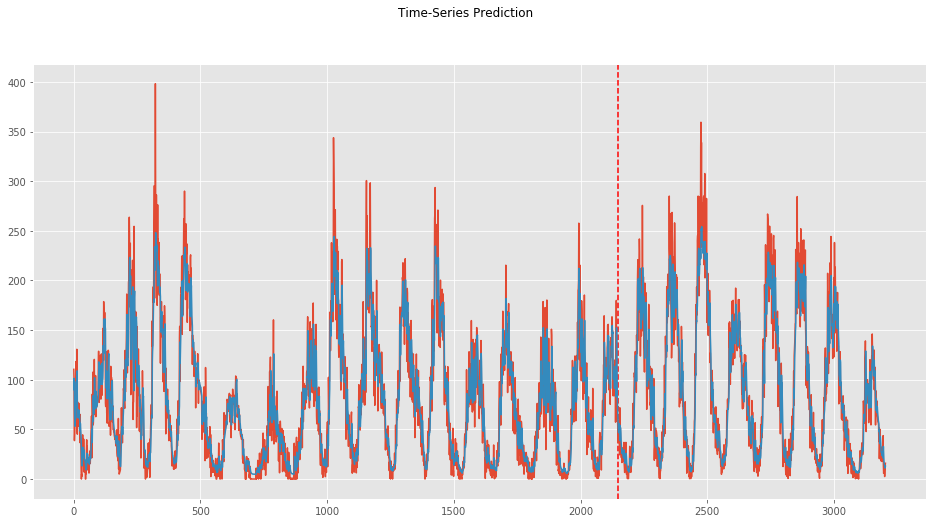

In [16]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

mse = ((dataY_plot - data_predict)**2).mean()

with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))
    plt.axvline(x=train_size, c='r', linestyle='--')

    plt.plot(dataY_plot)
    plt.plot(data_predict)
    print('NN MSE={}'.format(round(mse, 3)))
    plt.suptitle('Time-Series Prediction')
    plt.show()